In [2]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
# add_train = pd.read_csv(r'data/processed/robust.csv')
# train_data = pd.concat([train_data, add_train], axis=0)
# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3.5)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

scaled_train_data_df = scaled_train_data.copy()
scaled_test_data_df = scaled_test_data.copy()

grouped_train = scaled_train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", "air_to_motor_ratio"]


anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    print(n_features)
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.PowerfulConv1DLSTMAutoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)

14
Epoch [0/500], Loss: 0.0975075
Epoch [100/500], Loss: 0.0040060
Epoch [200/500], Loss: 0.0008198
Epoch [300/500], Loss: 0.0005552
Epoch [400/500], Loss: 0.0002819
finish 0.0type
14
Epoch [0/500], Loss: 0.1782134
Epoch [100/500], Loss: 0.0067855
Epoch [200/500], Loss: 0.0011173
Epoch [300/500], Loss: 0.0008400
Epoch [400/500], Loss: 0.0006647
finish 0.14285714285714285type
14
Epoch [0/500], Loss: 0.1232700
Epoch [100/500], Loss: 0.0020324
Epoch [200/500], Loss: 0.0010668
Epoch [300/500], Loss: 0.0007416
Epoch [400/500], Loss: 0.0005718
finish 0.2857142857142857type
14
Epoch [0/500], Loss: 1.2836103
Epoch [100/500], Loss: 0.0196312
Epoch [200/500], Loss: 0.0031211
Epoch [300/500], Loss: 0.0008718
Epoch [400/500], Loss: 0.0007093
finish 0.42857142857142855type
14
Epoch [0/500], Loss: 0.3365598
Epoch [100/500], Loss: 0.0080353
Epoch [200/500], Loss: 0.0014068
Epoch [300/500], Loss: 0.0007053
Epoch [400/500], Loss: 0.0004670
finish 0.5714285714285714type
14
Epoch [0/500], Loss: 0.8278918

In [3]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 143/1296 labels with value 1


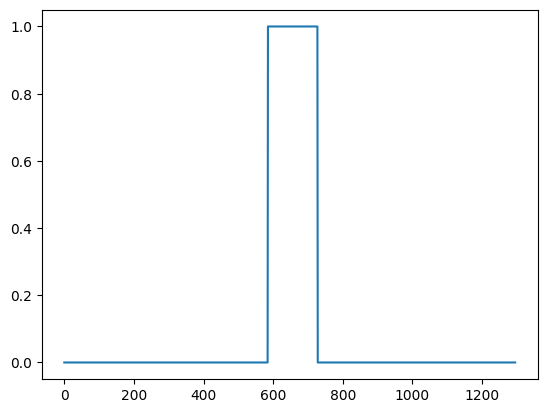

Chunk 1: 0/1107 labels with value 1


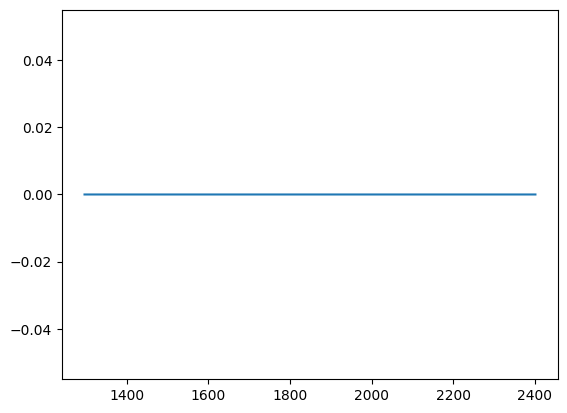

Chunk 2: 30/1098 labels with value 1


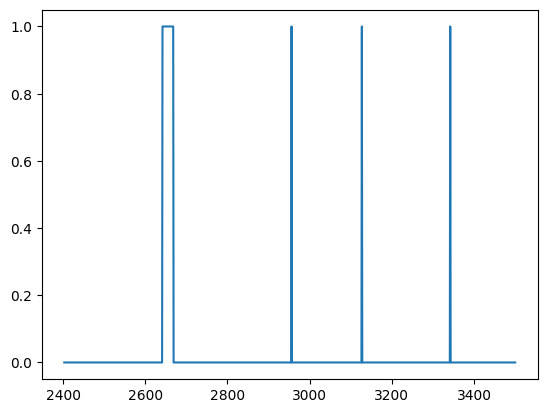

Chunk 3: 32/918 labels with value 1


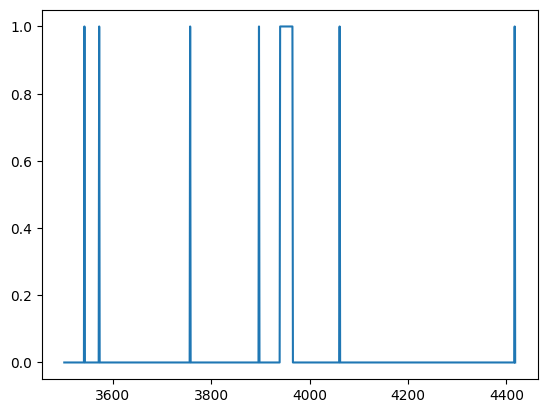

Chunk 4: 13/918 labels with value 1


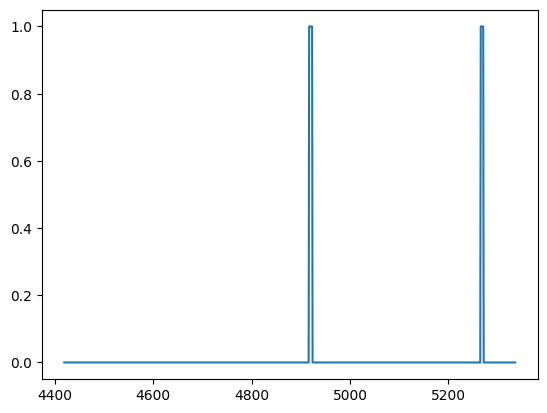

Chunk 5: 31/746 labels with value 1


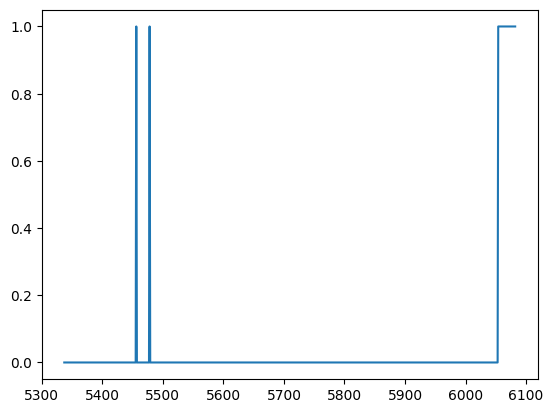

Chunk 6: 110/748 labels with value 1


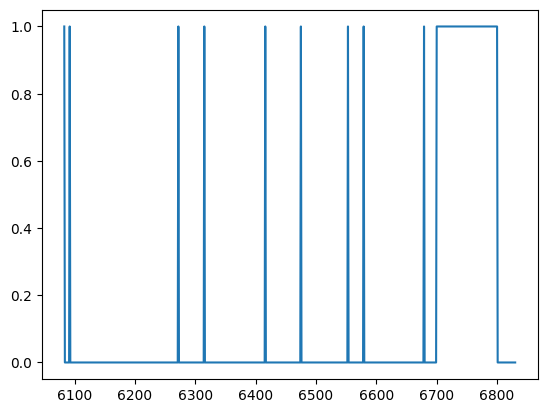

Chunk 7: 8/558 labels with value 1


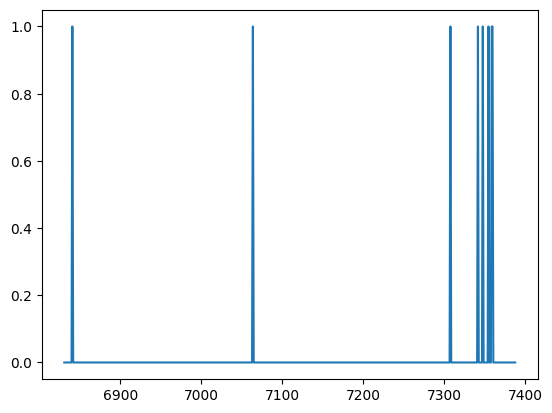

In [4]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)